In [561]:
import numpy as np
import typing 
from dataclasses import dataclass
from collections.abc import Callable
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.datasets import make_blobs
import copy
from sklearn.preprocessing import MinMaxScaler

In [90]:
def RBF(sigma: float = 1):
    def kernel(x: np.ndarray, y: np.ndarray):
        expo = -(np.sum((x[:,None,:] - y[None,:,:])**2, axis = -1))/(2*sigma) #Sum along the data dimension
        return np.exp(expo)
    return kernel

def Linear():
    def kernel(x: np.ndarray, y: np.ndarray):
        return x @ y.T
    return kernel

In [36]:
@dataclass
class Cluster:
    particles: np.ndarray[np.ndarray] #key-value between particle's id and its position
    nb_particle : int
    cluster_id: int
    diss_creation: float = 0

    def fuse(self, B):
        for b in B.particles:
            self.particles = np.append(self.particles, [b], axis = 0)
            self.nb_particle += 1
    
    def update_center(self):
        self.cluster_center = np.mean()

See https://en.wikipedia.org/wiki/Hierarchical_clustering#Cluster_Linkage for a list of linkage between two clusters. Linkage is a synonym of similarity here.

In [ ]:
#Compute the shortest distance between the particles of clusters x and y
def sim_min(x: np.ndarray[np.ndarray[float]], y: np.ndarray[np.ndarray[float]], dist: Callable = np.linalg.norm):
    return np.min(dist(x[:,None,:] - y[None,:,:], axis = -1))

def sim_max(x: np.ndarray[np.ndarray[float]], y: np.ndarray[np.ndarray[float]], dist: Callable = np.linalg.norm):
    return np.max(dist(x[:,None,:] - y[None,:,:], axis = -1))

def sim_avg(x: np.ndarray[np.ndarray[float]], y: np.ndarray[np.ndarray[float]], dist: Callable = np.linalg.norm):
    return np.mean(dist(x[:,None,:] - y[None,:,:], axis = -1))

def sim_centroids(x: np.ndarray[np.ndarray[float]], y: np.ndarray[np.ndarray[float]], dist: Callable = np.linalg.norm):
    return dist(np.mean(x, axis = 0), np.mean(y, axis = 0))**2

def sim_ward(x: np.ndarray[np.ndarray[float]], y: np.ndarray[np.ndarray[float]], dist: Callable = np.linalg.norm):
    #TO DO
    pass

class Hierarchical_Clustering:
    def __init__(self, nb_class: int, similarity: Callable = sim_min, distance: Callable = np.linalg.norm):
        self.distance = distance #Distance between two points
        self.similarity = similarity

        self.nb_class = nb_class

        self.clusters = np.array([]) # List of all clusters, independantly of their level

    def fit(self, particles: np.ndarray[np.ndarray]):
        """
        Implementation of hierarchical clustering for a set X of particles. Each clusters newly formed will be stacked in the list clusters.
        """
        for i, p in enumerate(particles):
            cluster = Cluster(np.array([p]), i, 1)
            self.clusters = np.append(self.clusters, cluster)

        while len(self.clusters) > self.nb_class:
            i_min, j_min = 0, 0
            Diss_min = np.infty
            for i in range(len(self.clusters)):
                for j in range(i + 1, len(self.clusters)):
                    Diss = self.similarity(self.clusters[i].particles, self.clusters[j].particles)
                    if Diss < Diss_min:
                        i_min, j_min = i, j
                        Diss_min = Diss
            
            self.clusters[i_min].diss_creation = Diss_min
            self.clusters[i_min].fuse(self.clusters[j_min])
            self.clusters = np.delete(self.clusters, j_min)
    
    def predict(self, X_test: np.ndarray):
        pred = []
        for x in X:
            idx_min_ = np.infty
            for i, c in enumerate(self.clusters):
                dist_matrix = self.similarity(x, c)
                if dist_matrix < c:
                    idx_min_ = i
            pred.append(idx_min)
        return pred
            
    def display(self):
        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue"]

        for i, c in enumerate(self.clusters):
            plt.scatter(c.particles[:,0], c.particles[:,1], color = color[i], label = f'cluster {i}')

In [ ]:
class DBSCAN:
    def __init__(self, min_pts: int, epsilon: float, distance: Callable = np.linalg.norm):
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.distance = distance
        self.nb_cluster = 0
        self.clusters = []
        self.clusterized = set()

    def neighborhood(self, X: np.ndarray, P: np.ndarray):
        """
        Return all points whose distance w.r.t P is smaller than epsilon.
        """
        dist = self.distance(X - P, axis = 1)
        idx = list(np.where(dist <= self.epsilon)[0])
        return idx

    def extend_cluster(self, X: np.ndarray, neighbor_x: np.ndarray, visited: set):
        cluster = self.clusters[-1]
        for n in neighbor_x:
            if n not in visited:
                visited.add(n)
                new_neighbor = self.neighborhood(X,X[n])
                if len(new_neighbor) - 1 > self.min_pts:
                    neighbor_x += new_neighbor
            if n not in self.clusterized:
                self.clusterized.add(n)
                cluster.particles = np.append(cluster.particles, np.array([X[n]]), axis = 0)

    def fit(self, X: np.ndarray):
        visited = set()
        for i, x in enumerate(X):
            if i not in visited:
                visited.add(i) #Add the particle's ID
                neighbor_x = self.neighborhood(X,x)
                if len(neighbor_x) - 1 < self.min_pts:
                    pass #Not the core of a cluster
                else:
                    #new cluster
                    self.clusterized.add(i)
                    new_cluster = Cluster(np.array([x]), 1, self.nb_cluster)
                    self.clusters.append(new_cluster)
                    self.extend_cluster(X, neighbor_x, visited)
                    self.nb_cluster += 1

    def display(self):
        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue", 'r', 'g', 'purple']

        for i, c in enumerate(self.clusters):
            try:
                plt.scatter(c.particles[:,0], c.particles[:,1], color = color[i], label = f'cluster {i}')
                plt.legend()
            except IndexError:
                break

In [647]:
class KMEAN:
    """
    Class to cluster data with Kmean approach.

    Parameters:
        Nb_cluster: The number of cluster.
        kernel: the kernel function to evaluate the similarity between two points
    """
    def  __init__(self, Nb_cluster: int, kernel: Callable, N_iter_max : int, epsilon: float, plot_init: bool = False):
        self.Nb_cluster = Nb_cluster #number of cluster
        self.kernel = kernel #
        self.clusters = [] #list of cluster
        self.N_iter_max = N_iter_max
        self.epsilon = epsilon
        self.plot_init = plot_init
    
    def dist_point_to_cluster(self, x: np.ndarray, cluster: Cluster):
        """
        Compute the distance between a point x to the cluster's centroid.
        Parameters:
            x (int): position of the point
            cluster: Cluster object
        
        Return:
            The distance in the RKHS between x and the cluster's centroid
        """
        n = cluster.nb_particle
        out = np.sum(self.kernel(x[None,:],x[None,:])) - 2/n*np.sum(self.kernel(x[None,:], cluster.particles)) + 1/n**2*np.sum(self.kernel(cluster.particles, cluster.particles))
        return out

    def dist_cluster_to_cluster(self, cluster_1: np.ndarray, cluster_2: Cluster):
        """
        Compute the distance between two cluster's centroid.
        Parameters:
            cluster_1: Cluster object
            cluster_1: Cluster object
        
        Return:
            The distance in the RKHS between x and the cluster's centroid
        """
        n = cluster_1.nb_particle
        m = cluster_2.nb_particle
        out = 1/n**2*np.sum(self.kernel(cluster_1.particles, cluster_1.particles)) - 2/(n*m)*np.sum(self.kernel(cluster_1.particles, cluster_2.particles)) + 1/m**2*np.sum(self.kernel(cluster_2.particles, cluster_2.particles))
        return out

    def kmean_init(self, X: np.ndarray):
        """Initialize the clustering with kmean++ algorithm"""

        visited = set()

        idx_center = np.random.randint(len(X))
        center = np.array([X[idx_center]])
        visited.add(idx_center)

        cluster = Cluster(center, 1, 0)
        self.clusters.append(cluster)
        scaler = MinMaxScaler(feature_range=(0,1))
        while len(self.clusters) < self.Nb_cluster:
            dist = []
            for i, x in enumerate(X):
                if i not in visited:
                    dist += [[i,min([self.dist_point_to_cluster(x, cluster) for cluster in self.clusters])]]
            list_dist = np.array(dist)[:,1]
            list_dist /= np.sum(list_dist)
            k = np.random.multinomial(1,list_dist)
            id_ = np.where(k == 1)[0]
            idx_x = np.array(dist)[id_, 0].astype(int).item()
            visited.add(idx_x)
            center = np.array([X[idx_x]])
            cluster = Cluster(center, 1, len(self.clusters))
            self.clusters.append(cluster)

        if self.plot_init:
            fig = plt.figure(figsize = (8,5))
            center = np.array([self.clusters[i].particles for i in range(self.Nb_cluster)])
            color = np.array(['r', 'g', 'b', 'yellow'])
            plt.scatter(X[:,0], X[:,1], color = color[y], alpha = .5)
            plt.scatter(center[:,0,0], center[:,0,1], color = 'black', label = "Cluster's center")
            plt.legend()


    def fit(self, X: np.ndarray):
        """Create cluster with Lloyd's algorithm. Initialization done with Kmeans ++"""

        self.kmean_init(X)
        prev_clusters = copy.deepcopy(self.clusters)
        delta = np.infty
        counter = 0

        while delta > self.epsilon and counter < self.N_iter_max:
            counter += 1
            cluster = [[] for _ in range(self.Nb_cluster)]
            for i, x in enumerate(X):
                new_c = np.argmin([self.dist_point_to_cluster(x, cluster) for cluster in prev_clusters]) #Find closest cluster
                cluster[new_c].append(x) #Add a particle

            #Update clusters
            for i in range(self.Nb_cluster):
                self.clusters[i].particles = np.array(cluster[i])
                self.clusters[i].nb_particle = len(cluster[i])

            delta = np.linalg.norm([self.dist_cluster_to_cluster(self.clusters[i], prev_clusters[i]) for i in range(self.Nb_cluster)])
            prev_clusters = copy.deepcopy(self.clusters)

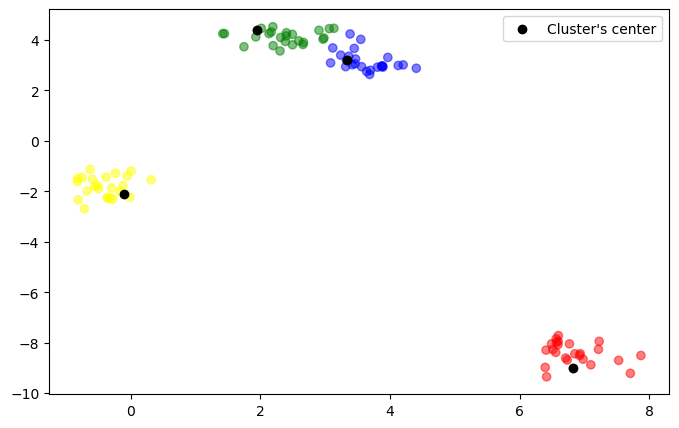

In [648]:
NB_CLUSTER = 4

X, y = make_blobs(n_samples=100, centers=NB_CLUSTER, n_features=2, cluster_std=.4)
kernel = Linear()
kmean = KMEAN(Nb_cluster=NB_CLUSTER, kernel = kernel, N_iter_max=10, epsilon=1e-3, plot_init=True)

kmean.fit(X)

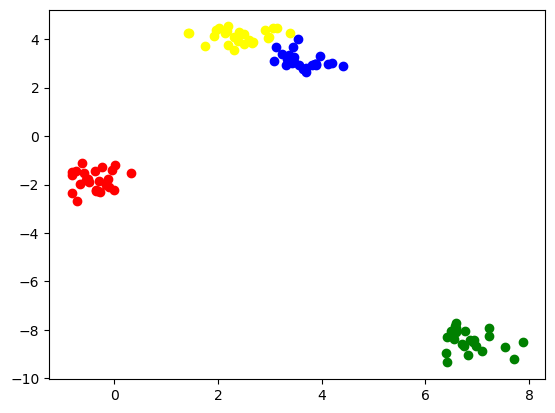

In [649]:
plt.scatter(kmean.clusters[0].particles[:,0], kmean.clusters[0].particles[:,1], color = color[0])
plt.scatter(kmean.clusters[1].particles[:,0], kmean.clusters[1].particles[:,1], color = color[1])
plt.scatter(kmean.clusters[2].particles[:,0], kmean.clusters[2].particles[:,1], color = color[2])
plt.scatter(kmean.clusters[3].particles[:,0], kmean.clusters[3].particles[:,1], color = color[3])

### Example

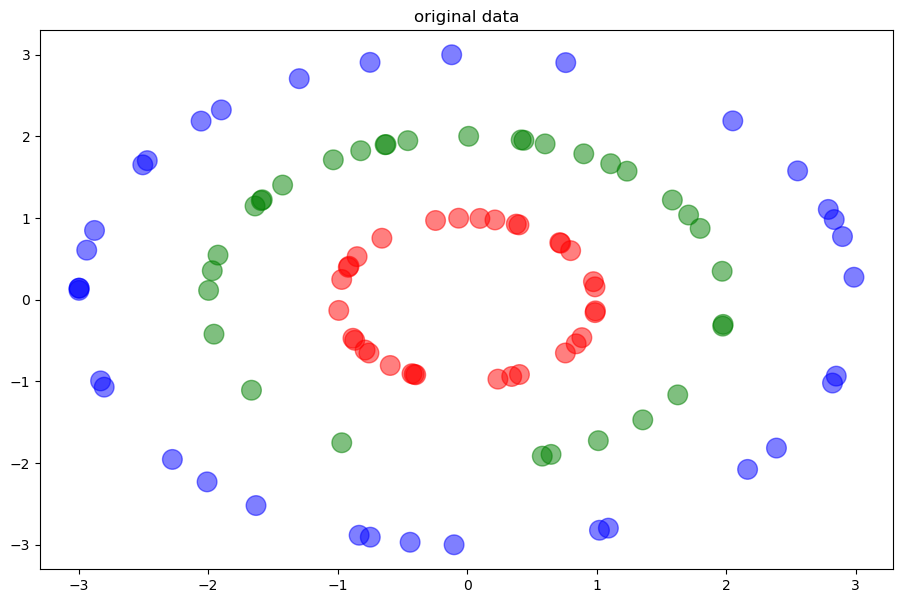

In [ ]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

scatter_label_points(train_set['x'], train_set['y'], title='original data')


### DBSCAN (density-based spatial clustering of applications with noise)


ici 5


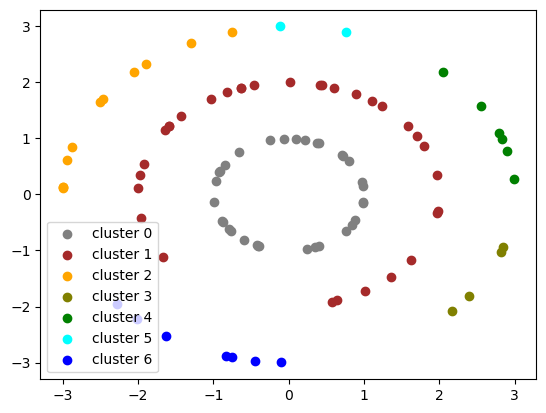

In [ ]:
db = DBSCAN(min_pts=2, epsilon=1)
db.fit(train_set['x'])

db.display()

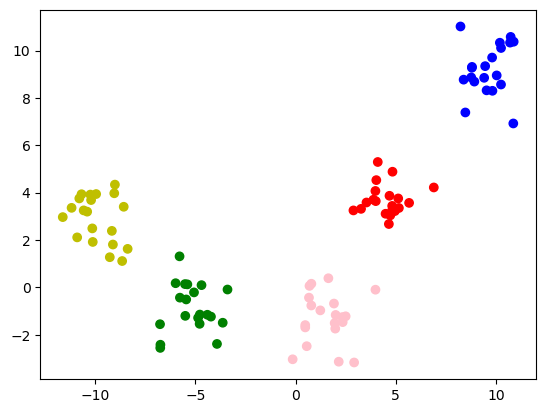

In [ ]:
X, y = make_blobs(n_samples=100, n_features=2, centers=5)

color = np.array(['r', 'g', 'b', 'pink', 'y'])
plt.scatter(X[:,0], X[:,1], color = color[y])

ici 9


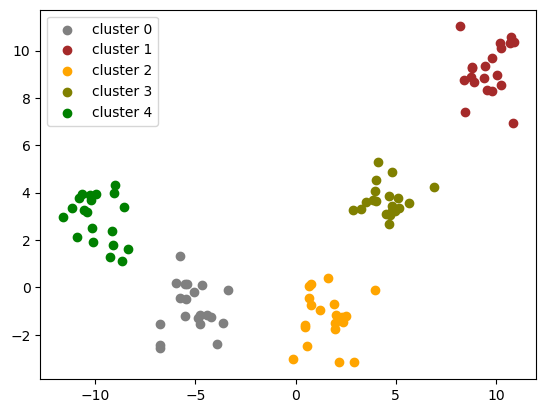

In [ ]:
db = DBSCAN(min_pts=1, epsilon=2)
db.fit(X)

db.display()

### Hierarchical cluster

Does not work at all for this kind of dataset.

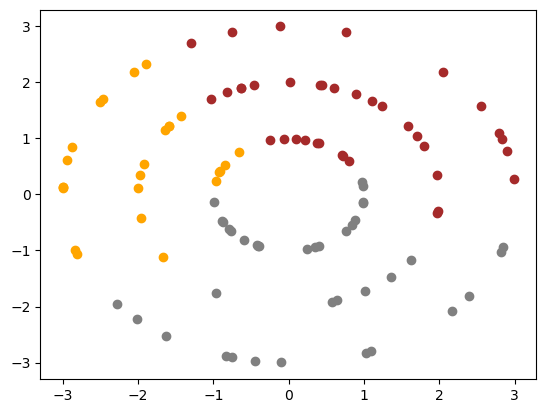

In [ ]:
HC = Hierarchical_Clustering(3, similarity=sim_avg)

HC.fit(train_set['x'])
HC.display()